In [1]:
#Dependencies
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import DataLoader
import itertools
import torch
import os

import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
                    
from collections import defaultdict
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchtools.optim import Ranger
# from ranger import Ranger
from adabelief_pytorch import AdaBelief

import adabelief_pytorch
import tqdm
import random
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity as cs
import seaborn as sns

## 1. 데이터 불러오기
- data: Books.csv
- 'item', 'user' 동일 데이터 중복 제거
- item_counts >= 10
- user_counts >= 20
- 총 13315087
- user unique: 256198
- item unique: 636312

In [2]:
datapath = './data/data_final.csv'
columns =  ['item', 'user', 'rating', 'timestamp']
df = pd.read_csv(datapath, sep = ",", names = columns, dtype = int)
df.astype(int)
df.head()

,item,user,rating,timestamp
0,122,3094405,5,1112140800
1,122,14877871,5,1466380800
2,122,7151803,5,1436400000
3,122,10069097,5,1383436800
4,122,13327705,5,1357084800


In [3]:
users_df = df.sort_values(["user","timestamp"]).set_index("user").fillna(0).drop("timestamp",axis=1)
users = dict(tuple(df.groupby("user"))) 

In [4]:
print(df.shape)

(13315087, 4)


In [5]:
df['user'].nunique()

256198

In [6]:
df['item'].nunique()

636312

data indexing

In [7]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = df['user'].unique()
item_unique = df['item'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
idx_to_user = {k:v for k,v in enumerate(user_unique)}
item_to_idx = {v:k for k,v in enumerate(item_unique)}
idx_to_item = {k:v for k,v in enumerate(item_unique)}

In [8]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = df['user'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(df):   # 모든 row가 정상적으로 인덱싱되었다면
    print('userId column indexing OK!!')
    df['user'] = temp_user_data   # data['userId']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('userId column indexing Fail!!')

# movie_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_item_data = df['item'].map(item_to_idx.get).dropna()
if len(temp_item_data) == len(df):
    print('itemId column indexing OK!!')
    df['item'] = temp_item_data
else:
    print('itemId column indexing Fail!!')
# up_data

userId column indexing OK!!
itemId column indexing OK!!


csr_matrix 및 embedding(ALS)

In [9]:
num_user = df['user'].nunique()
num_item = df['item'].nunique()

csr_data = csr_matrix((df['rating'], (df.user, df.item)), shape= (num_user, num_item))

In [10]:
#num_threads=-1
als_model = AlternatingLeastSquares(factors=100, regularization=0.01,use_gpu=False,
                                    iterations=15,dtype=np.float32,calculate_training_loss=True, num_threads=32)

#item x user
csr_data_transpose = csr_data.T
# csr_data_transpose
als_model.fit(csr_data_transpose)

In [11]:
item_embeddings_dict = {idx_to_item[i]:tf.convert_to_tensor(als_model.item_factors[i]) for i in tqdm.tqdm(range(num_item))}
user_embeddings_dict = {idx_to_user[i]:tf.convert_to_tensor(als_model.user_factors[i]) for i in tqdm.tqdm(range(num_user))}

len(user_embeddings_dict)

100%|██████████| 256198/256198 [00:02<00:00, 127171.65it/s]


256198

In [12]:
len(item_embeddings_dict)

636312

In [13]:
# item_embeddings_dict = np.load("./item_embeddings_dict_final_1.npy", allow_pickle=True).item()
# user_embeddings_dict = np.load("./user_embeddings_dict_final_1.npy", allow_pickle=True).item()

In [14]:
# np.save("item_embeddings_dict_final_1.npy", item_embeddings_dict)
# np.save("user_embeddings_dict_final_1.npy", user_embeddings_dict)

## 2. Train and Test Dataset

positive rating(4, 5)이 10개 이상인 user만

In [15]:
#Getting users with positive rating count greater than 10 
# 10 == 'N' positively interacted items
# from collections import defaultdict
# from collections import Counter
users_dict = defaultdict(dict)
users_id_list = set()
for user_id in users:
    rating_freq = Counter(users[user_id]["rating"].values)
    if rating_freq[4]+rating_freq[5]<10 :
        continue    
    else:
        users_id_list.add(int(user_id))
        users_dict[user_id]["item"] = users[user_id]["item"].values
        users_dict[user_id]["rating"] = users[user_id]["rating"].values

In [16]:
users_dict[14680070]["rating"]

array([5, 1, 2, 2, 2, 4, 4, 3, 4, 3, 5, 5, 3, 4, 5, 4, 5, 5, 4, 2, 1, 2,
       2, 2, 4, 5, 4, 1, 2, 4, 4, 3, 5, 4, 4, 5, 5, 1, 5])

In [17]:
users_id_list = np.array(list(users_id_list))
print(users_id_list)

[12058627 14680070  7340040 ...  9437172 12058615 11010043]


In [18]:
print(users_dict[12058627])

{'item': array([  28067,   41744,   81990,   94755,   95277,  104841,  122183,
        177661,  180581,  183115,  211122,  233553,  271914,  284884,
        286968,  300146,  339862,  343635,  364176,  364388,  364375,
        411644,  445202,  463239,  512989,  632956,  723559,  755129,
        809664,  819077,  819739,  878301,  951090, 1009123, 1010557,
       1042421, 1071233, 1107949, 1112160, 1125199, 1341839, 1347405,
       1487939, 1514645, 1580541, 1928572, 1956531, 1956306, 1962144,
       1972774, 1983891, 2009311, 2015798, 2031750, 2098284, 2127133,
       2233093, 2285383, 2295964, 2295969, 2295970, 2301303, 2305905,
       2388411, 2390438, 2542197,  527007, 2791251,  180670,  199910,
        271858,  293239,  441781,  538337,  544191,  766746,  955067,
        962416, 1010621, 1025036, 1151374, 1181909, 1889954, 2108769]), 'rating': array([4, 5, 4, 4, 5, 5, 3, 4, 5, 4, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 1, 5,
       5, 5, 4, 5, 5, 5, 1, 4, 5, 5, 5, 4, 5, 4, 5, 2, 5, 5, 4, 5,

In [19]:
len(users_id_list)

252110

In [20]:
#choosing default train_test_split of 25%
train_users,test_users = train_test_split(users_id_list)
print(train_users[:2])

[4833543 8747900]


In [21]:
print(test_users[:2])

[ 5840771 15333800]


positive rating(4, 5)을 10개까지 모아서 UserDataset 구성

In [22]:
from torch.utils.data import Dataset
class UserDataset(Dataset):
    def __init__(self,users_list,users_dict):
        self.users_list = users_list
        self.users_dict = users_dict

    def __len__(self):
        return len(self.users_list)

    def __getitem__(self,idx):
        user_id = self.users_list[idx]
        items = [('1',)]*10
        ratings = [('0',)]*10
        j=0
        for i,rate in enumerate(self.users_dict[user_id]["rating"]):
            if int(rate) >3 and j < 10:
                items[j] = self.users_dict[user_id]["item"][i]
                ratings[j] = self.users_dict[user_id]["rating"][i]
                j += 1
        # item = list(self.users_dict[user_id]["item"][:])
        # rating = list(self.users_dict[user_id]["rating"][:])
        size = len(items)
    
        return {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}

In [23]:
train_users_dataset = UserDataset(train_users,users_dict)
test_users_dataset = UserDataset(test_users,users_dict)

In [24]:
train_dataloader = DataLoader(train_users_dataset, batch_size=1)
test_dataloader = DataLoader(test_users_dataset, batch_size=1)

In [25]:
train_num = len(train_dataloader)
print(train_num)

189082


In [26]:
test_num = len(test_dataloader)
print(test_num)

63028


## 3. State Representation Models¶

### DDR-ave

In [27]:
''' input
    # dataloader에서 나온 return들
    # user_idb : 해당 user의 id 
    # itemb : 유저가 rating 한 item id 10개(tensor))
    # memory :  유저가 rating 한 item들 list 크기는 유저 * 10(item)  
    idx : user_list에서 user의 index
    output
    state : #state tensor shape [3,100]
'''
def drrave_state_rep(userid_b, memory, idx):
    user_num = idx
    H = [] #item embeddings
    user_n_items = memory
    user_embeddings = torch.Tensor(np.array(user_embeddings_dict[int(userid_b[0])]),).unsqueeze(0)

    for item in user_n_items:
        H.append(np.array(item_embeddings_dict[int(item)]))
    # avg_layer = nn.AvgPool1d(1)  # pooling layer 사용 
    weighted_avg_layer = nn.Conv1d(in_channels= 10, out_channels=1, kernel_size=1)
    item_embeddings = weighted_avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
    
    state = torch.cat([user_embeddings,user_embeddings*item_embeddings.T,item_embeddings.T])

    return state #state tensor shape [3,100] 

### DRR-u

In [28]:
# def drru_state_rep(userid_b,items,memory,idx):
#     user_num = idx
#     H = []
#     user_n_items = items
#     user_embeddings = user_embeddings_dict[userid_b[0]]
#     for i,item in enumerate(user_n_items):
#         ui = np.array(user_embeddings) * np.array(movie_embeddings_dict[item[0]])
#         H.append(ui)

#     pairs = list(itertools.combinations(memory[user_num], 2))
#     for item1,item2 in pairs:
#         pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
#         pair2 = np.array(movie_embeddings_dict[str(int(item2))])

#         product = pair1*pair2
#         H.append(product)
#     state = torch.Tensor(H,)
#     return state #state tensor shape [55,100]


### DRR-p

In [29]:
# def drrp_state_rep(items,memory,idx):
#   user_num = idx
#   H = []
#   user_n_items = items
#   for i,item in enumerate(user_n_items):
#     H.append(np.array(movie_embeddings_dict[item[0]]))
  
#   pairs = list(itertools.combinations(memory[user_num], 2))
#   for item1,item2 in pairs:
#     pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
#     pair2 = np.array(movie_embeddings_dict[str(int(item2))])
#     product = pair1*pair2
#     H.append(product)
#   state = torch.Tensor(H,)
#   return state

### state-rep

In [30]:
# just n items and their embeddings used to represent state
'''
def state_rep(item_b):
    state = []
    user_embeddings = np.zeros((len(columns),100))
    item_ids = list(item[0] for item in item_b)
    for i,subitem in enumerate(user_embeddings):
        if idx_to_id[i] in item_ids:
            user_embeddings[i] = np.array(item_embeddings_dict[idx_to_id[i]])
        else:
            user_embeddings[i] = np.zeros((100,))
    state = torch.Tensor(user_embeddings,)
    return torch.reshape(state,[-1]) 
'''

'\ndef state_rep(item_b):\n    state = []\n    user_embeddings = np.zeros((len(columns),100))\n    item_ids = list(item[0] for item in item_b)\n    for i,subitem in enumerate(user_embeddings):\n        if idx_to_id[i] in item_ids:\n            user_embeddings[i] = np.array(item_embeddings_dict[idx_to_id[i]])\n        else:\n            user_embeddings[i] = np.zeros((100,))\n    state = torch.Tensor(user_embeddings,)\n    return torch.reshape(state,[-1]) \n'

## 4. Actor, Critic 

In [31]:
# !pip install git+https://github.com/pabloppp/pytorch-tools@0.2.4 -U

In [32]:
#Actor Model:
#Generating an action a based on state s

# Input_dim 5500, output_dim 100, hidden_dim 256 for drr-u, p
# Input_dim 2100, output_dim 100, hidden_dim 256 for drr-ave

# embedding을 normalize(-1, 1) => tanh
# embedding을 standard scaling => PCA whitening

class Actor(torch.nn.Module):
    def __init__(self, input_dim, output_dim,hidden_dim):
        super(Actor, self).__init__()

        self.drop_layer = nn.Dropout(p=0.5)        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        x = F.relu(self.linear1(state.to(device)))
        # print(x.shape)
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        # print(x.shape)
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x # state = self.state_rep(state) 

In [33]:
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim):

        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
    
        self.linear1 = nn.Linear(input_dim + output_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

    def forward(self,state,action):    
        x = torch.cat([state.to(device), action.to(device)], 1)
        # print(x.shape)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

### PER buffer

SegmentTree

In [34]:
import operator


class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity


class MinSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(MinSegmentTree, self).__init__(
            capacity=capacity,
            operation=min,
            neutral_element=float('inf')
        )

    def min(self, start=0, end=None):
        """Returns min(arr[start], ...,  arr[end])"""

        return super(MinSegmentTree, self).reduce(start, end)

In [35]:
''' PER Replaybuffer '''

import numpy as np
#from segment_tree import MinSegmentTree, SumSegmentTree # This is baseline provided in OpenAI.

# Naive ReplayBuffer
class ReplayBuffer:
    """ Experience Replay Buffer which is implemented in DQN paper. https://www.nature.com/articles/nature14236 
    The detailed parameter is described in each method.
    """

    def __init__(self, 
                 buffer_size: ('int: total size of the Replay Buffer'), 
                 input_dim: ('int: a dimension of input data'),
                 action_dim: ('int: a dimension of action'),
                 batch_size: ('int: a batch size when updating')):

        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.save_count, self.current_size = 0, 0

        self.state_buffer = np.ones((buffer_size, input_dim), dtype=np.float32) 
        self.action_buffer = np.ones((buffer_size, action_dim), dtype=np.float32) 
        self.reward_buffer = np.ones(buffer_size, dtype=np.float32) 
        self.next_state_buffer = np.ones((buffer_size, input_dim), dtype=np.float32) 
        self.done_buffer = np.ones(buffer_size, dtype=np.int8)  

    def store(self, 
              state: np.float32, 
              action: np.float32, 
              reward: np.float32, 
              next_state: np.float32, 
              done: np.int8):

        self.state_buffer[self.save_count] = state
        self.action_buffer[self.save_count] = action
        self.reward_buffer[self.save_count] = reward
        self.next_state_buffer[self.save_count] = next_state
        self.done_buffer[self.save_count] = done

        self.save_count = (self.save_count + 1) % self.buffer_size
        self.current_size = min(self.current_size+1, self.buffer_size)

    def batch_load(self):
        indices = np.random.randint(self.current_size, size=self.batch_size)
        return dict(
                states=self.state_buffer[indices], 
                actions=self.action_buffer[indices],
                rewards=self.reward_buffer[indices],
                next_states=self.next_state_buffer[indices], 
                dones=self.done_buffer[indices]) 

# ReplayBuffer for Prioritized Experience Replay. 
class PrioritizedReplayBuffer(ReplayBuffer):
    
    def __init__(self, buffer_size, input_dim, action_dim, batch_size, alpha):
        
        super(PrioritizedReplayBuffer, self).__init__(buffer_size, input_dim, action_dim, batch_size)
        
        # For PER. Parameter settings. 
        self.max_priority, self.tree_idx = 1.0, 0
        self.alpha = alpha

        tree_capacity = 1
        while tree_capacity < self.buffer_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def store(self, 
              state: np.float32, 
              action: np.float32, 
              reward: np.float32, 
              next_state: np.ndarray, 
              done: np.int8):
        
        super().store(state, action, reward, next_state, done)
        
        self.sum_tree[self.tree_idx] = self.max_priority ** self.alpha
        self.min_tree[self.tree_idx] = self.max_priority ** self.alpha
        self.tree_idx = (self.tree_idx + 1) % self.buffer_size

    def batch_load(self, beta):
        
        indices, p_total = self._sample_indices_with_priority()
        weights = self._cal_weight(indices, p_total, self.current_size, beta)
        return dict(
                states=self.state_buffer[indices], 
                actions=self.action_buffer[indices],
                rewards=self.reward_buffer[indices],
                next_states=self.next_state_buffer[indices], 
                dones=self.done_buffer[indices],
                weights=weights,
                indices=indices) 

    def update_priorities(self, indices, priorities):
        
        for idx, priority in zip(indices, priorities.flatten()):
            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha
            
            self.max_priority = max(self.max_priority, priority)
    
    def _sample_indices_with_priority(self):

        p_total = self.sum_tree.sum() 
        segment = p_total / self.batch_size
        segment_list = [i*segment for i in range(self.batch_size)]
        samples = [np.random.uniform(a, a+segment) for a in segment_list]
        indices = [self.sum_tree.find_prefixsum_idx(sample) for sample in samples]
        
        return indices, p_total
    
    def _cal_weight(self, indices, p_total, N, beta):
        
        p_min = self.min_tree.min() / p_total
        max_weight = (p_min*N) ** (-beta) 
        
        p_samples = np.array([self.sum_tree[idx] for idx in indices]) / p_total
        weights = (p_samples*N)**(-beta)/max_weight
        return weights
    
if __name__=='__main__':
    buffer_size = 100
    input_dim = 300
    action_dim = 100
    batch_size = 16
    alpha = 0.6
    beta = 0.4
    buffer = PrioritizedReplayBuffer(buffer_size, input_dim, action_dim, batch_size, alpha)
    for i in range(50):
        state = np.ones(input_dim)
        action = 1
        reward = 1
        next_state = np.ones(input_dim)
        done = 1
        buffer.store(state, action, reward, next_state, done)
    '''
    print(buffer.alpha)
    print(buffer.max_priority)
    print(buffer.batch_load(beta)['states'].shape)
    print(buffer.batch_load(beta)['actions'].shape)
    print(buffer.batch_load(beta)['rewards'].shape)
    print(buffer.batch_load(beta)['next_states'].shape)
    print(buffer.batch_load(beta)['dones'].shape)
    print(buffer.batch_load(beta)['weights'].shape)
    print(buffer.batch_load(beta)['indices'].__len__())
    '''

In [36]:
'''
state = drrave_state_rep(userid_b,item_b,memory,idx_b)
state_rep =  torch.reshape(state,[-1])
next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
next_state_rep = torch.reshape(next_state,[-1])
#R.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy()
)
'''

'\nstate = drrave_state_rep(userid_b,item_b,memory,idx_b)\nstate_rep =  torch.reshape(state,[-1])\nnext_state = drrave_state_rep(userid_b,item_b,memory,idx_b)\nnext_state_rep = torch.reshape(next_state,[-1])\n#R.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy()\n)\n'

In [37]:
device = 'cpu'
# device = torch.device('cuda')

In [38]:
#used for plotting purposes
p_loss = []
v_loss = []

DDPG Update

In [39]:
def ddpg_update(batch_size=32, 
                gamma = 0.6,
                min_value=-np.inf,
                max_value=np.inf,
                soft_tau=1e-2,
                beta=0.4):
    
    batch = replay_buffer.batch_load(beta)
    weights = torch.FloatTensor(batch['weights'].reshape(-1, 1)).to(device) # device 는 GPU 번호
    states = torch.FloatTensor(batch['states']).to(device)
    next_states = torch.FloatTensor(batch['next_states']).to(device)
    actions = torch.FloatTensor(batch['actions']).to(device)
    rewards = torch.FloatTensor(batch['rewards'].reshape(-1, 1)).to(device)
    dones = torch.FloatTensor(batch['dones'].reshape(-1, 1)).to(device)
    
    # policy loss
    policy_loss = -(weights * value_net(states, policy_net(states))).mean()
    p_loss.append(policy_loss) 
    
    # value loss
    # print(states.shape)
    # print(actions.shape)
    value = value_net(states, actions)
    next_actions   = target_policy_net(next_states) 
    mask = 1 - dones
    expected_value = (rewards + gamma * mask * target_value_net(next_states, next_actions.detach())).to(device) 
    expected_value = torch.clamp(expected_value, min_value, max_value) 
    sample_wise_loss = F.smooth_l1_loss(value, expected_value.detach(), reduction="none") 
        
    value_loss = (weights * sample_wise_loss).mean()
    v_loss.append(value_loss)
    
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
    
    # For PER: update priorities of the samples.
    epsilon_for_priority = 1e-8
    sample_wise_loss = sample_wise_loss.detach().cpu().numpy()
    batch_priorities = sample_wise_loss + epsilon_for_priority
    replay_buffer.update_priorities(batch['indices'], batch_priorities)

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)


In [40]:
# #initializing actor and critic networks for drru and drrp state representation

# value_net = Critic(5500,100,256).to(device)
# policy_net = Actor(5500,100,256).to(device)

# target_value_net = Critic(5500,100,256).to(device)
# target_policy_net = Actor(5500,100,256).to(device)

    
# target_policy_net.eval()
# target_value_net.eval()

# for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
#     target_param.data.copy_(param.data)

# for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
#     target_param.data.copy_(param.data)

# value_criterion = nn.MSELoss()
# value_optimizer      = Ranger(value_net.parameters(),  lr=1e-4)
# policy_optimizer     = Ranger(policy_net.parameters(), lr=1e-4)

In [41]:
#initializing for drrave state representation

value_net = Critic(300,100,256).to(device)
policy_net = Actor(300,100,256).to(device)

target_value_net = Critic(300,100,256).to(device)
target_policy_net = Actor(300,100,256).to(device)

target_policy_net.eval()
target_value_net.eval()

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion = nn.MSELoss()
value_optimizer = AdaBelief(value_net.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = True)
policy_optimizer = AdaBelief(policy_net.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = True)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-O

In [62]:
buffer_size = 500000
replay_buffer = PrioritizedReplayBuffer(buffer_size, input_dim, action_dim, batch_size, alpha)
memory = np.ones((train_num,10))*-1

In [43]:
# torch.sort??

In [44]:
def get_action(state, action_emb, userid_b, items):
    action_emb = torch.reshape(action_emb,[1,100]).unsqueeze(0).to(device)
    m = torch.bmm(action_emb,items).squeeze(0)  #torch.bmm : batch 행렬 곱연산
    _, indices = torch.sort(m, descending=True)
    index_list = list(indices[0])
    for i in index_list: 
        if users_dict[int(userid_b[0])]["item"][i] not in preds:     
            preds.add(users_dict[int(userid_b[0])]["item"][i]) 
            return int(i) 

In [45]:
def update_memory(memory,action,idx):
    memory[idx] = list(memory[idx,1:])+[action]

In [46]:
rate = 0

In [47]:
it = iter(train_dataloader)
first = next(it)
item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
print(item_b)

[tensor([21300]), tensor([97262]), tensor([499884]), tensor([639811]), tensor([718409]), tensor([1028357]), tensor([1168112]), tensor([1168110]), tensor([1195383]), tensor([1243520])]


In [48]:
first = next(it)
item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
print(item_b)

[tensor([38785]), tensor([40072]), tensor([99910]), tensor([100240]), tensor([177846]), tensor([181437]), tensor([184205]), tensor([214574]), tensor([219904]), tensor([244323])]


In [49]:
first['rating']

[tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5])]

In [50]:
print(int(userid_b[0]))

8747900


In [51]:
print(item_b[1])

tensor([40072])


In [52]:
memory = np.ones((train_num,10))*-1
memory[idx_b] = [item[0] for item in item_b]
print(memory[idx_b])

[ 38785.  40072.  99910. 100240. 177846. 181437. 184205. 214574. 219904.
 244323.]


In [53]:
print(item_b[1][0])

tensor(40072)


In [54]:
print(memory)

[[-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]
 [ 3.87850e+04  4.00720e+04  9.99100e+04 ...  2.14574e+05  2.19904e+05
   2.44323e+05]
 [-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]
 ...
 [-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]
 [-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]
 [-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]]


In [55]:
print(idx_b)

tensor([1])


### ENV & ou_noise

In [56]:
class OfflineEnv:

    def __init__(self, dataloader, users_dict, item_embeddings_dict):
        
        self.dataloader = iter(dataloader)
        self.users_dict = users_dict
        
        self.data = next(self.dataloader) # {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}
        self.user_history = self.users_dict[int(self.data['userid'])]
        
        self.item_embedding = torch.Tensor([np.array(item_embeddings_dict[item]) for item in users_dict[int(self.data['userid'][0])]['item']])
        self.items = self.item_embedding.T.unsqueeze(0)

        self.memory = [item[0] for item in self.data['item']]
        self.done = 0

        self.related_books = self.generate_related_books()
        self.viewed_pos_books = []
    
    def generate_related_books(self):
        related_movie = []
        items = self.user_history['item'][10:]
        ratings = self.user_history['rating'][10:]

        for item, rating in zip(items, ratings):
            if rating > 3:
                related_movie.append(item)
        
        return related_movie

    def reset(self):
        self.data = next(self.dataloader)
        self.memory = [item[0] for item in self.data['item']]
        self.user_history = self.users_dict[int(self.data['userid'])]
        self.done = 0
        self.item_embedding = torch.Tensor([np.array(item_embeddings_dict[item]) for item in users_dict[int(self.data['userid'][0])]['item']])
        self.items = self.item_embedding.T.unsqueeze(0)
        self.related_books = self.generate_related_books()
        self.viewed_pos_books = []

    def update_memory(self,action):
        self.memory = list(self.memory[1:]) + [self.user_history['item'][action]]
        
    def step(self, action):
        
        ### Env : step
        ### 
        rating = int(self.user_history["rating"][action])
        normal_rating = (int(rating)-3)/2
        reward = torch.Tensor((normal_rating,))
        #ep_reward = ep_reward + ratings

        if reward > 0:
            self.update_memory(action)
            self.viewed_pos_books.append(action)
    
        if len(self.viewed_pos_books) == len(self.related_books):
            self.done = 1
        
        return self.memory, reward, self.done


        #next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
        #next_state_rep = torch.reshape(next_state,[-1])

In [68]:
import scipy.sparse as sp
import torch.utils.data as td

#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_dim, mu=0.0, theta=0.15, max_sigma=0.4, min_sigma=0.4, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_dim
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return torch.tensor([action + ou_state]).float().cpu()

## 5. Training

In [69]:
# OfflineEnv??

In [70]:
ou_noise = OUNoise(100, decay_period=10)
params = {
    'ou_noise': True
}

In [71]:
class OfflineEnv2:

    def __init__(self, dataloader, users_dict, item_embeddings_dict):
        
        self.dataloader = iter(dataloader)
        self.users_dict = users_dict
        
        self.data = next(self.dataloader) # {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}
        self.user_history = self.users_dict[int(self.data['userid'])]
        
        self.item_embedding = torch.Tensor([np.array(item_embeddings_dict[item]) for item in users_dict[int(self.data['userid'][0])]['item']])
        self.items = self.item_embedding.T.unsqueeze(0)

        self.memory = [item[0] for item in self.data['item']]
        self.done = 0

        self.related_books = self.generate_related_books()
        self.viewed_pos_books = []
    
    def generate_related_books(self):
        related_movie = []
        items = self.user_history['item'][10:]
        ratings = self.user_history['rating'][10:]

        for item, rating in zip(items, ratings):
            if rating > 3:
                related_movie.append(item)
        
        return related_movie

    def reset(self):
        self.data = next(self.dataloader)
        self.memory = [item[0] for item in self.data['item']]
        self.user_history = self.users_dict[int(self.data['userid'])]
        self.done = 0
        self.item_embedding = torch.Tensor([np.array(item_embeddings_dict[item]) for item in users_dict[int(self.data['userid'][0])]['item']])
        self.items = self.item_embedding.T.unsqueeze(0)
        self.related_books = self.generate_related_books()
        self.viewed_pos_books = []

    def update_memory(self,action):
        self.memory = list(self.memory[1:]) + [self.user_history['item'][action]]
        
    def step(self, action):
        
        ### Env : step
        ### 
        rating = int(self.user_history["rating"][action])
        normal_rating = (int(rating)-3)/2
        reward = torch.Tensor((normal_rating,))
        #ep_reward = ep_reward + ratings

        if reward > 0:
            self.update_memory(action)
            self.viewed_pos_books.append(action)
    
        if len(self.viewed_pos_books) == len(self.related_books):
            self.done = 1
        
        return self.memory, reward, self.done


In [72]:
env = OfflineEnv2(train_dataloader, users_dict, item_embeddings_dict)
preddict = dict()
accum_rewards = []
mean_rewards = []

for episode in tqdm.tqdm(range(train_num-1)):
    ep_reward = 0
    batch_size= 8

    item_b, rating_b, size_b, userid_b, idx_b = env.data['item'], env.data['rating'], env.data['size'], env.data['userid'], env.data['idx']
    memory = env.memory
    preds = set(item_b)
    state = drrave_state_rep(userid_b,memory,idx_b)
    items = env.items.to(device)
    
    done = 0
    user_len = len(env.user_history['item'])
    # print("User Length", user_len)

    # 만약 추천할 대상이 없다면
    if len(env.user_history['rating']) == len(preds):
        continue

    # 5개만 추천하기
    for j in range(5):
        if done == 0:
            state_rep =  torch.reshape(state,[-1])
            action_emb = policy_net(state_rep)
            
            if params['ou_noise']:
                action_emb = ou_noise.get_action(action_emb.detach().cpu().numpy()[0], j)
                action_emb = action_emb.squeeze(0)
            action = get_action(state, action_emb, userid_b, items)
            
            memory, reward, done = env.step(action)
        
            ep_reward += reward
            
            next_state = drrave_state_rep(userid_b, memory, idx_b)
            next_state_rep = torch.reshape(next_state,[-1])

            replay_buffer.store(state_rep.detach().cpu().numpy(), 
                                action_emb.detach().cpu().numpy(), 
                                reward, next_state_rep.detach().cpu().numpy(), done)
            if replay_buffer.current_size > batch_size:
                ddpg_update(batch_size=batch_size)

            state = next_state
        else:
            break
    env.reset()
    accum_rewards.append(ep_reward)
    preddict[userid_b[0]] = preds

  0%|          | 0/189081 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
100%|██████████| 189081/189081 [6:27:59<00:00,  8.12it/s]   


In [73]:
len(env.user_history['item'])

29

In [74]:
preddict

{tensor(4833543): {tensor([21300]),
  21300,
  tensor([97262]),
  tensor([499884]),
  tensor([639811]),
  tensor([718409]),
  718409,
  tensor([1028357]),
  tensor([1168110]),
  tensor([1168112]),
  tensor([1195383]),
  1195383,
  tensor([1243520]),
  1637000,
  2155776},
 tensor(8747900): {tensor([38785]),
  tensor([40072]),
  tensor([99910]),
  tensor([100240]),
  140510,
  tensor([177846]),
  tensor([181437]),
  tensor([184205]),
  tensor([214574]),
  tensor([219904]),
  tensor([244323]),
  600242,
  1232159,
  1437825,
  2155863},
 tensor(5530470): {tensor([31535]),
  tensor([31536]),
  tensor([31537]),
  tensor([214925]),
  tensor([214970]),
  tensor([214971]),
  tensor([214972]),
  tensor([214973]),
  tensor([214974]),
  tensor([216313]),
  218116,
  1395327,
  1395480,
  1395683,
  2021128},
 tensor(14413645): {tensor([4708]),
  tensor([5557]),
  tensor([5863]),
  tensor([35942]),
  tensor([37888]),
  tensor([97223]),
  tensor([97475]),
  tensor([99666]),
  tensor([101812]),
  t

In [75]:
reward

tensor([1.])

In [82]:
accum_rewards

[tensor([2.5000]),
 tensor([3.]),
 tensor([5.]),
 tensor([1.]),
 tensor([4.]),
 tensor([5.]),
 tensor([5.]),
 tensor([2.]),
 tensor([2.]),
 tensor([5.]),
 tensor([3.]),
 tensor([2.5000]),
 tensor([5.]),
 tensor([5.]),
 tensor([5.]),
 tensor([5.]),
 tensor([0.5000]),
 tensor([3.]),
 tensor([3.5000]),
 tensor([5.]),
 tensor([2.5000]),
 tensor([5.]),
 tensor([4.5000]),
 tensor([1.5000]),
 tensor([3.]),
 tensor([5.]),
 tensor([4.5000]),
 tensor([0.5000]),
 tensor([1.]),
 tensor([2.5000]),
 tensor([4.]),
 tensor([3.]),
 tensor([4.5000]),
 tensor([3.]),
 tensor([0.]),
 tensor([4.5000]),
 tensor([2.]),
 tensor([4.]),
 tensor([3.5000]),
 tensor([5.]),
 tensor([4.5000]),
 tensor([4.]),
 tensor([5.]),
 tensor([5.]),
 tensor([1.]),
 tensor([4.5000]),
 tensor([2.5000]),
 tensor([4.]),
 tensor([4.5000]),
 tensor([5.]),
 tensor([0.]),
 tensor([4.5000]),
 tensor([5.]),
 tensor([4.5000]),
 tensor([2.5000]),
 tensor([1.]),
 tensor([2.5000]),
 tensor([5.]),
 tensor([5.]),
 tensor([4.]),
 tensor([3.5000]

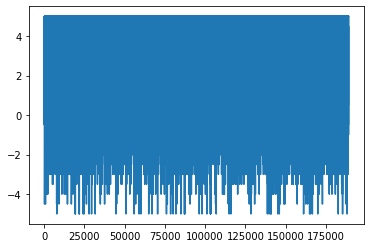

In [81]:
plt.plot(accum_rewards)

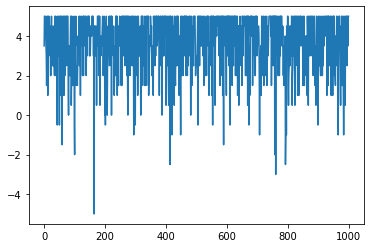

In [90]:
plt.plot(accum_rewards[-1000:])

In [77]:
len(memory)

10

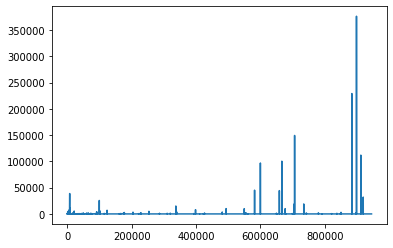

In [89]:
plt.plot(v_loss)

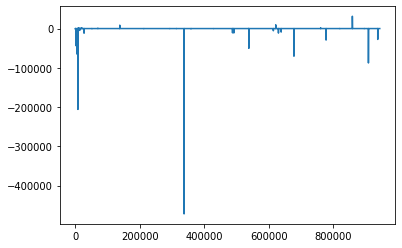

In [79]:
plt.plot(p_loss)

유저의 히스토리 order와 rating간의 균형을 맞춰야 할 것.  
  
0. 거리에 따른 정의  

    1) reward정의 - nDCG의 개념을 이용해서, log나 혹은 다른 함수값으로 time scaling으로 reward scaling을 한다. (몇 번째 이상부터는 고정값으로)  
    2) next state의 조건으로 몇 번째까지 허용할지. --> 1번째??   
      
    
1. 가까운 것 ~ 먼 것 + 높은 것: reward 양수 (nDCG 개념, ?몇 째 이후부터는 0)  

2. 가까운 것 + 낮은 것: 최소값  

3. 먼 것 + 낮은 것: 최소값 (edited) 


## 6. Testing

In [88]:
#prediction algorithm
it2 = iter(test_dataloader)
precision = 0
test_pred_dict = dict()
for j in range(len(test_dataloader)-1):  #session 돌리기 : timestamps 내에서 items들 
    first = next(it2)
    item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
    memory[idx_b] = [item[0] for item in item_b]
    state = drrave_state_rep(userid_b,memory,idx_b)
    count = 0
    test_pred = set()
    for j in range(5):  #policy network5번 돌리기 , 추천 5번 하기
        state_rep =  torch.reshape(state,[-1])
        action_emb = policy_net(state_rep)   # policy_net = actor : items들의 선호도 (rating)
        action = get_action(state,action_emb,userid_b,item_b,test_pred)
        rate = int(users_dict[userid_b[0]]["rating"][action])
        try:
            rating = (int(rate)-3)/2
        except:
            rating = 0
        reward = torch.Tensor((rating,))

        if reward > 0:
            count += 1
            update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)
        next_state = drrave_state_rep(userid_b,memory,idx_b)
        state = next_state
    precision += count/5
    test_pred_dict[userid_b[0]] = test_pred
print("p",precision/(len(test_dataloader)-1))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [83]:
#Getting Cosine similarity of recommended items for a particular userid that has been evaluated
# from sklearn.metrics.pairwise import cosine_similarity as cs
# import seaborn as sns

def get_cosine_sim(userid):
    test_pred = test_pred_dict[userid]
    for i,item in enumerate(users_dict[userid]["item"]):
        if item in test_pred:
            print(item,":",users_dict[userid]["rating"][i])

    test_embed = []
    for item in test_pred:
        test_embed.append(np.array(item_embeddings_dict[int(item)]))

    test_embed_array = np.array(test_embed)

    return test_embed_array

test_embed_array = get_cosine_sim(userid_b[0])
ax = sns.heatmap(cs(test_embed_array), linewidth=0.5)
plt.show()


NameError: name 'test_pred_dict' is not defined

## 7. Saving and Loading Models

In [ ]:
PATH = '/content/gdrive/My Drive/RLProject/Models/drravepolicy_net.pth'
torch.save(policy_net.state_dict(), PATH)

In [ ]:
value_PATH = '/content/gdrive/My Drive/RLProject/Models/drravevalue_net.pth'
torch.save(value_net.state_dict(), value_PATH)

tpolicy_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetpolicy_net.pth'
torch.save(target_policy_net.state_dict(), tpolicy_PATH)

tvalue_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetvalue_net.pth'
torch.save(target_value_net.state_dict(), tvalue_PATH)

In [ ]:
np.save('/content/gdrive/My Drive/RLProject/Models/train_dataloader',train_dataloader)
np.save('/content/gdrive/My Drive/RLProject/Models/test_dataloader',test_dataloader)

In [ ]:
policy_net = Actor(5500,100,256)
policy_net.load_state_dict(torch.load(PATH))
policy_net.eval()

value_net = Critic(5500,100,256)
value_net.load_state_dict(torch.load(value_PATH))
value_net.eval()

target_policy_net = Actor(5500,100,256)
target_policy_net.load_state_dict(torch.load(tpolicy_PATH))
target_policy_net.eval()

target_value_net = Critic(5500,100,256)
target_value_net.load_state_dict(torch.load(tvalue_PATH))
target_value_net.eval()


In [ ]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

train_data = np.load('/content/gdrive/My Drive/RLProject/Models/train_users.npy')

In [ ]:
np.load = np_load_old